In [227]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels. tsa.stattools import adfuller
import statsmodels.api as sm
import pandas as pd
import matplotlib.pyplot as plt
from prophet import Prophet
import numpy as np
%matplotlib inline
from scipy import stats

In [228]:
url = 'https://raw.githubusercontent.com/Yorko/mlcourse.ai/main/data/wiki_machine_learning.csv'
data = pd.read_csv(url, sep = ' ')

In [229]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 384 entries, 81 to 372
Data columns (total 7 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   date    384 non-null    object
 1   count   384 non-null    int64 
 2   lang    384 non-null    object
 3   page    384 non-null    object
 4   rank    384 non-null    int64 
 5   month   384 non-null    int64 
 6   title   384 non-null    object
dtypes: int64(3), object(4)
memory usage: 24.0+ KB


In [230]:
data['date'] = pd.to_datetime(data.date)

In [231]:
data

,date,count,lang,page,rank,month,title
81,2015-01-01,1414,en,Machine_learning,8708,201501,Machine_learning
80,2015-01-02,1920,en,Machine_learning,8708,201501,Machine_learning
79,2015-01-03,1338,en,Machine_learning,8708,201501,Machine_learning
78,2015-01-04,1404,en,Machine_learning,8708,201501,Machine_learning
77,2015-01-05,2264,en,Machine_learning,8708,201501,Machine_learning
...,...,...,...,...,...,...,...
382,2016-01-16,1644,en,Machine_learning,8708,201601,Machine_learning
381,2016-01-17,1836,en,Machine_learning,8708,201601,Machine_learning
376,2016-01-18,2983,en,Machine_learning,8708,201601,Machine_learning
375,2016-01-19,3389,en,Machine_learning,8708,201601,Machine_learning


# 1. Facebook Prophet

In [232]:
#  Для того, чтобы посмотреть на качество модели, отбросим из обучающей выборки последние 30 дней.
predictions = 30

data = data[["date", "count"]]
data.columns = ["ds", "y"]
train_data = data[:-predictions].copy()

<AxesSubplot: xlabel='ds'>

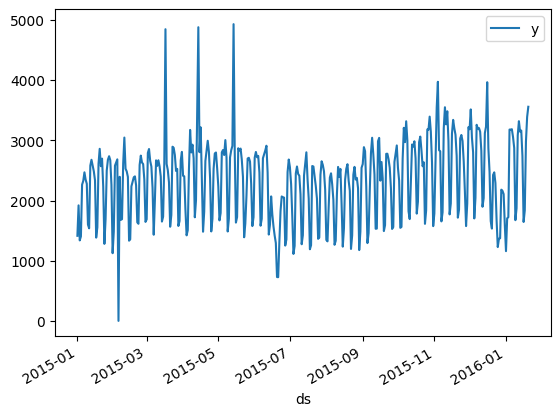

In [233]:
data.plot(x = 'ds', y = 'y')

In [234]:
model = Prophet()
model.fit(train_data)
future = model.make_future_dataframe(periods=predictions)
forecast = model.predict(future)


04:12:04 - cmdstanpy - INFO - Chain [1] start processing
04:12:04 - cmdstanpy - INFO - Chain [1] done processing


       yhat
383  3420.0


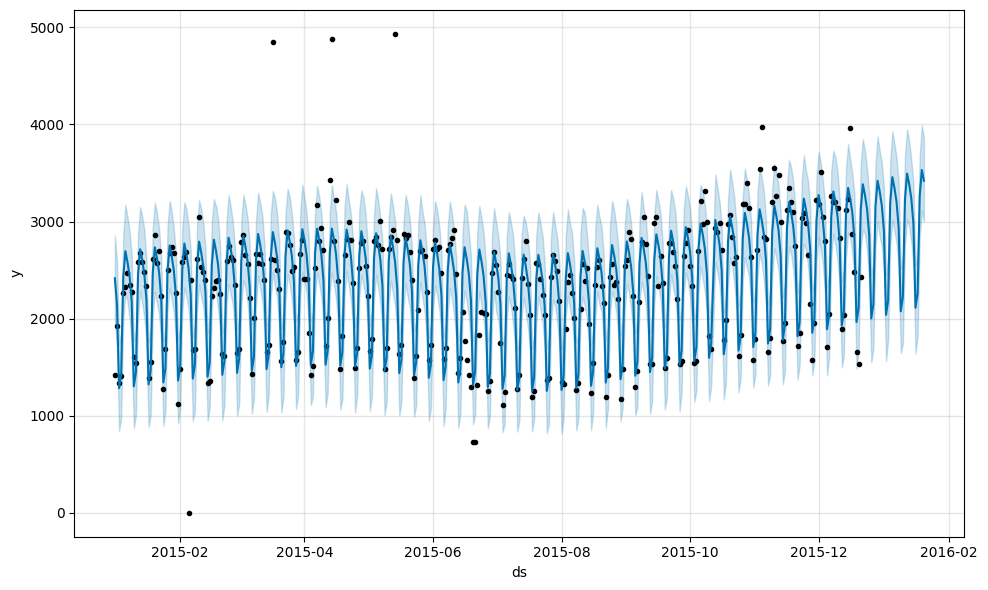

In [235]:
print(round(forecast[['yhat']].tail(1))) # прогноз на 20 января
model.plot(forecast)
plt.show()

In [236]:
mae = np.mean(abs((data['y'][-predictions:] - forecast['yhat'][-predictions:])))
print('Средняя абсолютная ошибка mae: ',mae)

Средняя абсолютная ошибка mae:  961.1461946598702


In [237]:
mape = np.mean(abs((data['y'][-predictions:] - forecast['yhat'][-predictions:])/data['y'][-predictions:]))
print('Средняя абсолютная процентная ошибка Mape: ',mape*100,'%')

Средняя абсолютная процентная ошибка Mape:  49.84935230694089 %


Видим, что разница между значениями почти 50%, что говорит о не очень хорошей модели

# 2. Sarimax

In [238]:
adfuller(data['y'])

(-3.2997371711587187,
 0.014890227037347792,
 15,
 368,
 {'1%': -3.4482453822848496,
  '5%': -2.8694261442901396,
  '10%': -2.5709711770439507},
 5416.814821320779)

p_value<0.05, значит ряд стационарный.

In [239]:
model = SARIMAX(train_data['y'],
                order=(3, 0, 0),
                seasonal_order=(0, 0, 1, 12))

result = model.fit()

In [240]:
start = len(train_data['y'])
end = len(train_data['y']) + len(data['y'][-predictions:]) - 1

prediction = result.predict(start, end)
prediction

354    2435.395812
355    2235.345275
356    2351.258266
357    2336.405457
358    2006.508041
359    1969.913299
360    1757.781587
361    2056.572248
362    2097.434052
363    2193.347580
364    2203.433268
365    1948.096122
366    1918.953185
367    1950.638350
368    1927.100679
369    1890.132473
370    1867.078718
371    1847.403718
372    1824.669793
373    1801.520141
374    1779.462386
375    1757.829792
376    1736.264851
377    1714.930163
378    1693.905340
379    1673.145794
380    1652.629023
381    1632.362210
382    1612.346774
383    1592.577107
Name: predicted_mean, dtype: float64

In [241]:
mae = np.mean(abs((data['y'][-predictions:] - prediction)))
print('Средняя абсолютная ошибка mae: ',mae)

Средняя абсолютная ошибка mae:  929.0251892282711


In [242]:
mape = np.mean(abs((data['y'][-predictions:] - prediction)/data['y'][-predictions:]))
print('Средняя абсолютная процентная ошибка Mape: ',mape*100,'%')

Средняя абсолютная процентная ошибка Mape:  33.811541799684406 %
